In [119]:
data = read.table('bulkRNA.txt', header = TRUE, row.names = 1)

In [74]:
load('atlas_20230203.RDATA')

In [55]:
library(stringr)
coldata = data.frame(row.names = colnames(data)[1:7], group = substring(colnames(data)[1:7], 1, 3))
head(coldata)

,group
,<chr>
INT.1.intCt,INT
INT.2.intCt,INT
INT.3.intCt,INT
KLR.4.intCt,KLR
INT.5.intCt,INT
KLR.6.intCt,KLR


In [136]:
cts = data[,1:7]
norm = data[,8:14]
cts = cts[apply(norm, 1, function(x) sum(x > 1)) > 3,]
dim(cts)

[1] 7671    7

In [137]:
dds <- DESeqDataSetFromMatrix(countData = cts,
                              colData = coldata,
                              design= ~ group)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in design formula are characters, converting to factors"


In [138]:
dds <- DESeq(dds)
resultsNames(dds)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



[1] "Intercept"        "group_KLR_vs_INT"

In [139]:
res <- results(dds, name='group_KLR_vs_INT')


In [140]:
summary(res)


out of 7671 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 33, 0.43%
LFC < 0 (down)     : 136, 1.8%
outliers [1]       : 135, 1.8%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [141]:
res <- res[order(res$padj),]
head(res)

log2 fold change (MLE): group KLR vs INT 
Wald test p-value: group KLR vs INT 
DataFrame with 6 rows and 6 columns
                    baseMean log2FoldChange     lfcSE      stat      pvalue
                   <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSMUSG00000068855  2120.967       -3.03814  0.293479 -10.35215 4.09173e-25
ENSMUSG00000064220 14782.642       -2.71648  0.303004  -8.96514 3.09894e-19
ENSMUSG00000075031  6386.926       -3.99547  0.478266  -8.35408 6.59447e-17
ENSMUSG00000071478   342.980      -11.25103  1.395798  -8.06064 7.58952e-16
ENSMUSG00000032777   458.028      -11.66795  1.458245  -8.00136 1.23049e-15
ENSMUSG00000097810   383.856      -11.41315  1.465798  -7.78631 6.89971e-15
                          padj
                     <numeric>
ENSMUSG00000068855 3.08352e-21
ENSMUSG00000064220 1.16768e-15
ENSMUSG00000075031 1.65653e-13
ENSMUSG00000071478 1.42987e-12
ENSMUSG00000032777 1.85460e-12
ENSMUSG00000097810 8.66604e-12

In [142]:
library(org.Mm.eg.db)
res$symbol = 
mapIds(
  org.Mm.eg.db,
  keys = rownames(res),
  column = 'SYMBOL',
  keytype = 'ENSEMBL')


'select()' returned 1:many mapping between keys and columns



In [143]:
res = as.data.frame(res)

In [154]:
res %>% filter(symbol == 'S1pr5')

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,symbol
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSMUSG00000045087,1908.926,2.710682,1.0342,2.621042,0.008766138,0.2370157,S1pr5


In [176]:
norm = data[,8:14]

norm = norm[apply(norm, 1, function(x) sum(x > 1) > 6),]

Warning message:
"Removed 136 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 7654 rows containing missing values (`geom_text_repel()`)."


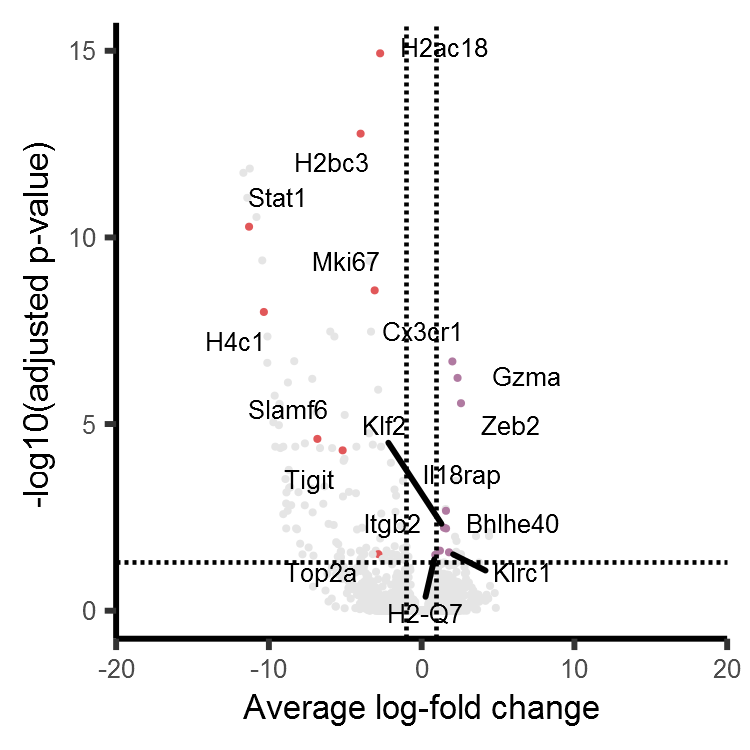

In [297]:
library(dplyr)
library(ggrepel)
bulk = res
options(repr.plot.height = 2.5, repr.plot.width = 2.5, repr.plot.res = 300)
bulk$label = bulk$symbol
bulk$label[bulk$padj > .05] = NA
lab =c('Cx3cr1', 'Gzma', 'Zeb2', 'Il18rap', 'Klf2', 'Klrc1', 'Itgb2', 'Klrc1', 'H2-Q7', 'H2ac20', 'H2ac18', 'H2bc3', 'Stat1', 'Mki67', 'H4c1', 'Slamf6', 'Tigit', 'Top2a', 'Bhlhe40')

bulk$label[!bulk$symbol %in% lab] = NA
bulk$col = 'A'
bulk$col[!is.na(bulk$label) & bulk$log2FoldChange < 0] = 'B'
bulk$col[!is.na(bulk$label) & bulk$log2FoldChange > 0] = 'C'
pal = c('grey90', '#E15759', '#B07AA1')
g1 = ggplot(bulk, aes(x = log2FoldChange, y = -log10(padj))) + geom_point(size = .8, stroke =0, aes(color = col)) + geom_text_repel(aes(label = label), max.overlaps = 200, size = 2.1167) + 
scale_x_continuous(limits = c(-20, 20), expand = c(0,0)) + theme_classic() + Axis_themes + 
geom_hline(yintercept = -log10(.05), linetype = 'dashed', size = .3937)+ geom_vline(xintercept = 1, linetype = 'dashed', size =.3937) + 
 geom_vline(xintercept = -1, linetype = 'dashed', size =.3937) + scale_y_continuous(limits = c(0, 15)) + scale_color_manual(values = pal) + guides(color = FALSE) + 
labs(x = 'Average log-fold change', y = '-log10(adjusted p-value)')
g1


In [147]:
a = readRDS('markers_int_klr.RDS')

In [148]:
a$otherfc = bulk$log2FoldChange[match(rownames(a), bulk$symbol)]
a$otherp = bulk$padj[match(rownames(a), bulk$symbol)]


Warning message:
"Removed 30 rows containing missing values (`geom_text_repel()`)."


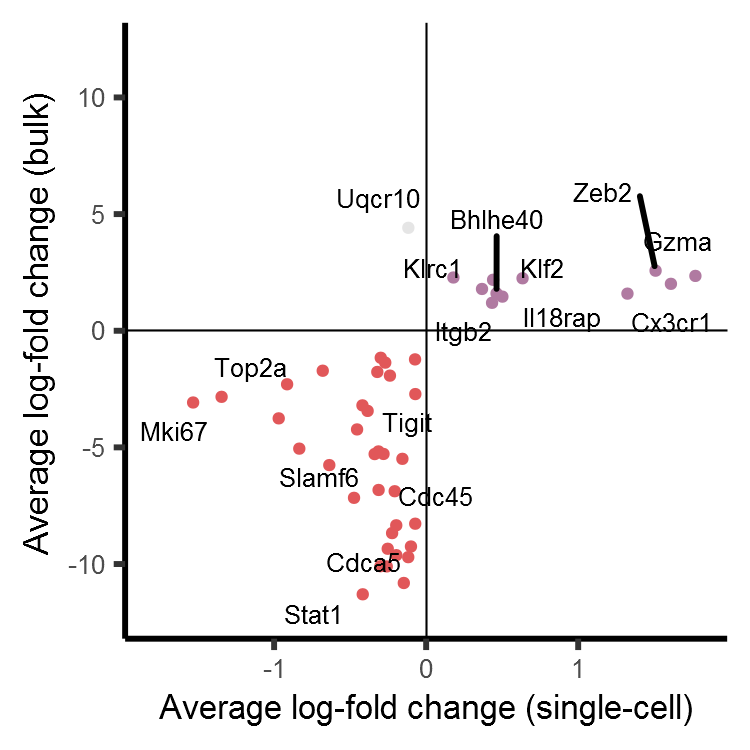

In [285]:
library(ggpubr)
label = c()
a$label = a$gene
a$label[!a$gene %in% c(lab, 'Uqcr10', 'Cdca5', 'Cdc45')] = NA
a$col = 'A'
a$col[a$otherfc < 0] = 'B'
a$col[ a$otherfc > 0] = 'C'
a$col[a$dir == 0] = 'A'
a$dir = as.numeric(a$otherfc*a$avg_log2FC > 0)
g2 = ggplot(a %>% filter(otherp < 0.05, abs(otherfc) < Inf, p_val_adj < 0.05, abs(otherfc) > 1, abs(avg_log2FC) > .05), aes(x = avg_log2FC, y = otherfc)) + geom_point(size = .5, aes(color = col))+ #stat_cor(method = 'spearman', size = 2.1167) + 
labs(x = 'Average log-fold change (single-cell)', y = 'Average log-fold change (bulk)') + theme_classic() + Axis_themes + scale_x_continuous(limits = c(-1.8, 1.8)) + 
scale_y_continuous(limits = c(-12, 12)) + geom_hline(yintercept = 0, size = .177) + geom_vline(xintercept = 0, size = .177) + geom_text_repel(aes(label = label), size = 2.1167)+ scale_color_manual(values = pal) + 
guides(color = FALSE)
g2

In [309]:
a %>% filter(otherp < 0.05, abs(otherfc) < Inf, p_val_adj < 0.05, abs(otherfc) > 1, abs(avg_log2FC) > .05) %>% group_by(dir) %>% summarize(n = n())

dir,n
<dbl>,<int>
0,1
1,45


In [266]:
signature_up = bulk$symbol[bulk$padj < 0.05 & bulk$log2FoldChange > 0 & abs(bulk$log2FoldChange) < Inf][1:20]
signature_dn = bulk$symbol[bulk$padj < 0.05 & bulk$log2FoldChange < 0 & abs(bulk$log2FoldChange) < Inf][1:20]

signature_up = signature_up[!is.na(signature_up)]
signature_dn = signature_dn[!is.na(signature_dn)]

In [267]:
library(Seurat)
seurat = AddModuleScore(seurat, features = list(a = signature_up), name  = 'Up')
seurat = AddModuleScore(seurat, features = list(a = signature_dn), name  = 'Down')

Warning message:
"The following features are not present in the object: Jade3, not searching for symbol synonyms"
Warning message:
"The following features are not present in the object: H2ac20, H2ac18, H2bc3, H2ac7, H2bc15, H4c1, H2ac10, H2bu2, not searching for symbol synonyms"


In [268]:
sub = subset(seurat, cells = colnames(seurat)[seurat@meta.data$tissue == 'Spleen'])


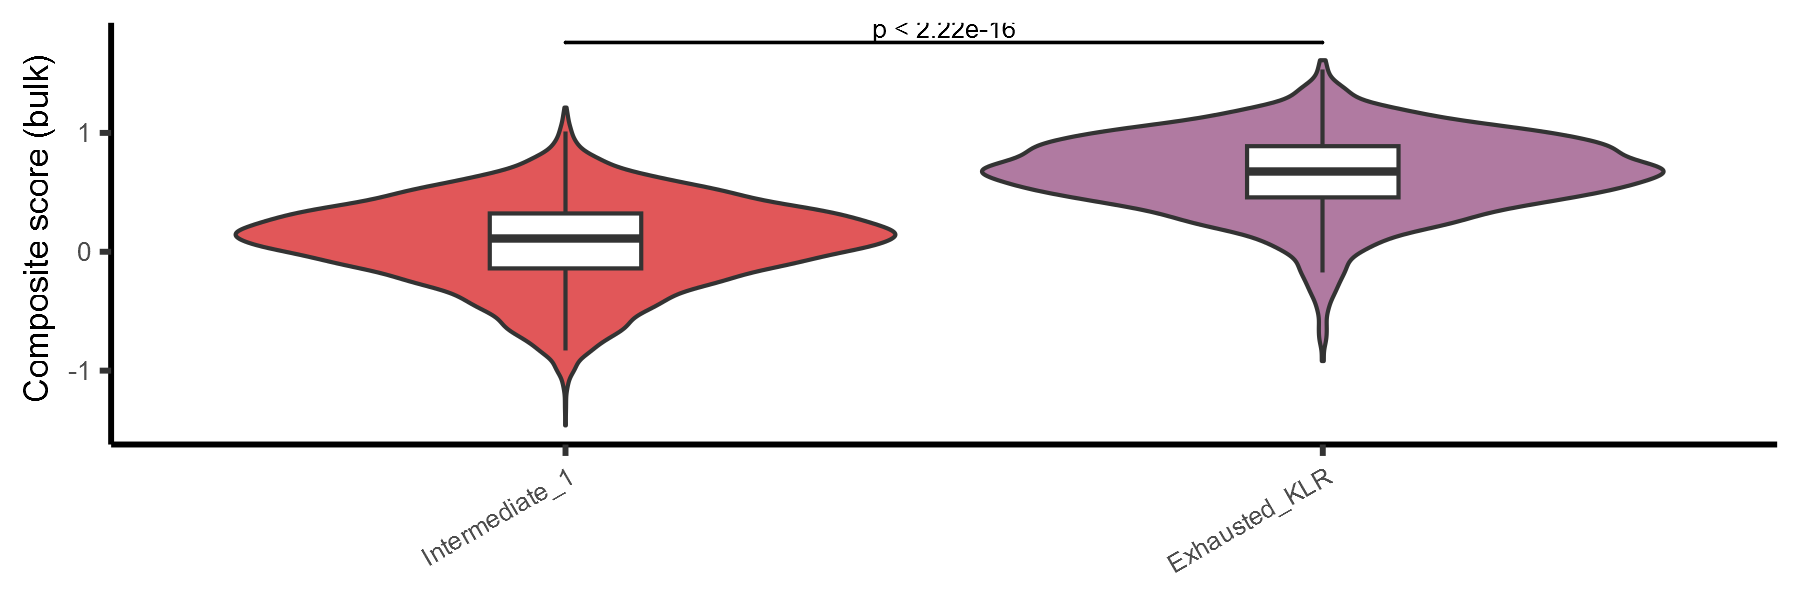

In [306]:
g3= ggplot(seurat@meta.data %>% filter(label %in% c('Intermediate_1', 'Exhausted_KLR')) , aes(x = label, y = (Up1) - (Down1))) + 
geom_violin(aes(fill = label), size = .355) +
geom_boxplot(outlier.shape = NA, width = .2, size = .355) + 
theme(axis.text.x = element_text(angle = 45, hjust = 1))+
stat_compare_means(comparison = list(c(1,2)), size = 2.1167, tip.length = 0) + theme_classic() + Axis_themes + scale_fill_manual(values = pal[c(2,3)]) + 
theme(axis.text.x = element_text(angle = 30, hjust = 1)) + labs(x = c(), y = 'Composite score (bulk)') + guides(fill = FALSE)
g3

Warning message:
"Removed 136 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 7654 rows containing missing values (`geom_text_repel()`)."
Warning message:
"Removed 30 rows containing missing values (`geom_text_repel()`)."


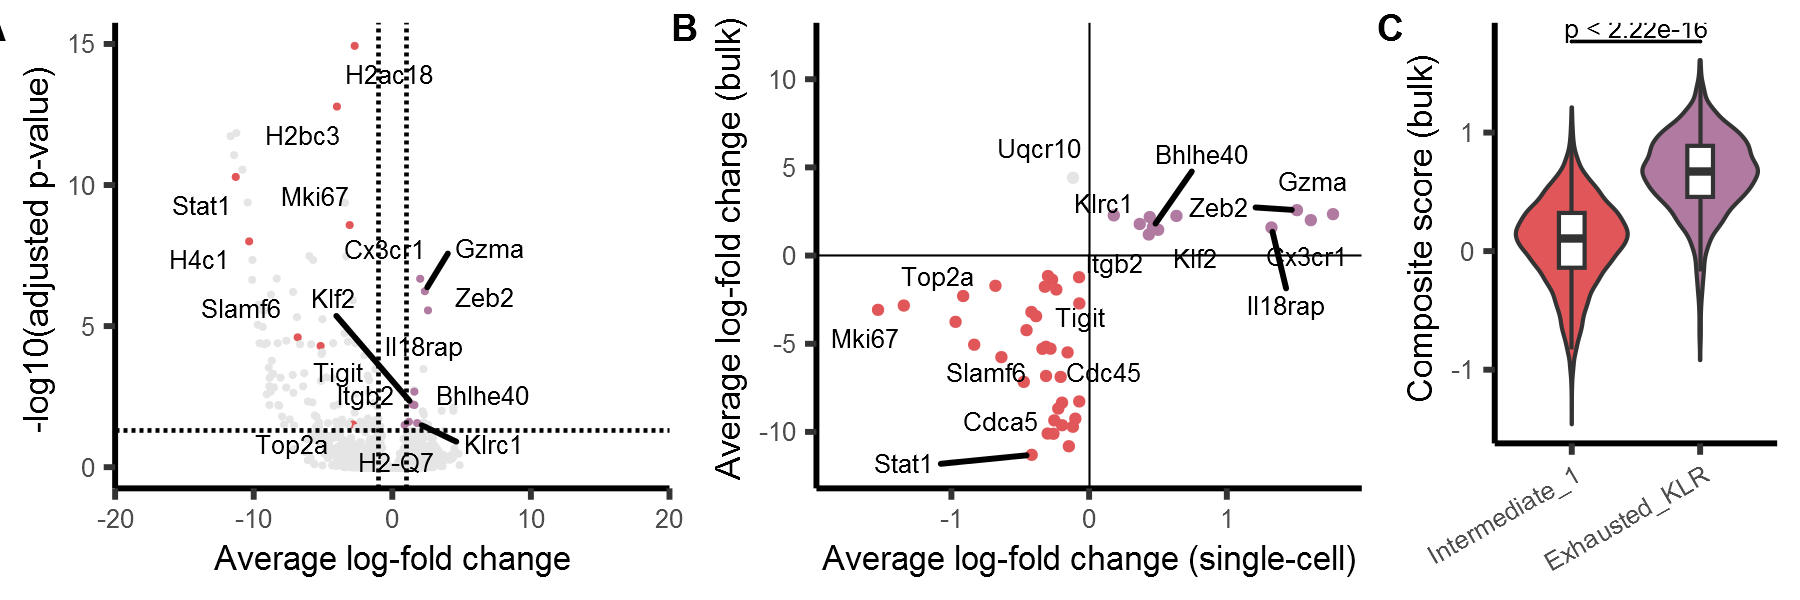

In [307]:
options(repr.plot.width = 6, repr.plot.height = 2)
cowplot::plot_grid(g1, g2, g3, ncol = 3, rel_widths = c(1, 1, .6), label_size = 9, labels = c('A', 'B', 'C'), label_x = -.05)
ggsave('Supp_bulk.pdf', height = 2, width = 6, useDingbats = FALSE)